In [1]:
from training.pretrained_bert import PretrainedBert
from training.pretrained_distil_bert import PretrainedDistilBert
from training.pretrained_roberta import PretrainedRoberta
from tests.similarity import item_comparison
from comparison.product_comparator import ProductComparator
from preprocessing.dataset_loader import PletsDataset
import numpy as np
from torch.utils.data import DataLoader
from evaluation.hierarchial_metric import HierachialMetric
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from training.trainer import Trainer
import pickle

C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using the CPU instead.


## Demonstration of raw embedding comparison
Results of running the product comparison algorithm on abstract test.   
This part only uses the last two steps of the pipeline, that is embedding generation (in this case, based on a pretrained model without further finetuning) and embedding similarity calculation.
Both the value of similarity metric and the execution time will be measured. Three different models will be used to compare those values between them - Bert, DistilBert, and RoBERTa.

### Bert

In [15]:
model = ProductComparator(PretrainedBert().train())
item_comparison(model, "Red apple", "Green apple")
item_comparison(model, "Red apple", "Lemon")
item_comparison(model, "Red apple", "Brick")
item_comparison(model, "Red apple", "Warsaw University of Technology")

######## Comparison ########
# Red apple                #
# Green apple              #
############################
# Similarity: 0.99615      #
# Execution time: 36.74ms  #
############################

######## Comparison ########
# Red apple                #
# Lemon                    #
############################
# Similarity: 0.98853      #
# Execution time: 36.37ms  #
############################

######## Comparison ########
# Red apple                #
# Brick                    #
############################
# Similarity: 0.98222      #
# Execution time: 36.72ms  #
############################

############ Comparison ############
# Red apple                        #
# Warsaw University of Technology  #
####################################
# Similarity: 0.96787              #
# Execution time: 36.10ms          #
####################################


### DistilBert

In [16]:
model = ProductComparator(PretrainedDistilBert().train())
item_comparison(model, "Red apple", "Green apple")
item_comparison(model, "Red apple", "Lemon")
item_comparison(model, "Red apple", "Brick")
item_comparison(model, "Red apple", "Warsaw University of Technology")

######## Comparison ########
# Red apple                #
# Green apple              #
############################
# Similarity: 0.99838      #
# Execution time: 18.22ms  #
############################

######## Comparison ########
# Red apple                #
# Lemon                    #
############################
# Similarity: 0.99120      #
# Execution time: 17.93ms  #
############################

######## Comparison ########
# Red apple                #
# Brick                    #
############################
# Similarity: 0.99088      #
# Execution time: 17.83ms  #
############################

############ Comparison ############
# Red apple                        #
# Warsaw University of Technology  #
####################################
# Similarity: 0.97690              #
# Execution time: 18.35ms          #
####################################


### RoBERTa

In [7]:
model = ProductComparator(PretrainedRoberta().train())
item_comparison(model, "Red apple", "Green apple")
item_comparison(model, "Red apple", "Lemon")
item_comparison(model, "Red apple", "Brick")
item_comparison(model, "Red apple", "Warsaw University of Technology")

config.json: 100%|██████████| 481/481 [00:00<?, ?B/s] 
C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aurif\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

######## Comparison ########
# Red apple                #
# Green apple              #
############################
# Similarity: 0.99992      #
# Execution time: 35.76ms  #
############################

######## Comparison ########
# Red apple                #
# Lemon                    #
############################
# Similarity: 0.99961      #
# Execution time: 35.76ms  #
############################

######## Comparison ########
# Red apple                #
# Brick                    #
############################
# Similarity: 0.99960      #
# Execution time: 35.59ms  #
############################

############ Comparison ############
# Red apple                        #
# Warsaw University of Technology  #
####################################
# Similarity: 0.99949              #
# Execution time: 37.63ms          #
####################################


As we can see, in all three models the similarities follow expected values - it is higher when compared items are close to each other (like `red apple` and `green apple`), and lower when items are different (like `red apple` and `Warsaw University of Technology`). All values are really high, reaching even 0.9949 for the most different pair of items. This is consistent with results usually present when using cosine distance between embeddings as similarity metrics. As we mostly care about the order of the similarities and not the absolute values themselves, this is not going to be a significant problem. A normalization of values with a non-linear scale can be later applied in the pipeline to make the values more intuitive to interpret.

What's also worth noting are the execution times of each of the models. Both BERT and RoBERTa achieved about 35 milliseconds per pair, while DistilBERT achieved significantly better result, that being 18 milliseconds per pair. This time can be additionally improved by running the pipeline on the GPU, which we were unfortunately unable to do due to technical difficulties.

Overall, the results above show that a cosine metric on BERT embeddings can be used as a good multi-hierarchical measure, when if done on an only pretrained model.

## Demonstration of feature extraction
Results of the feature extraction based on product title and description. The following code loads preprocessed data from a locally stored cache and displays few example triplets from the training dataset. The feature extraction is done through the use of a large language model, through an API hosted on hugging face, with the use of a single prompt per item. The training dataset consists of triples with base, a similar item, and a differing item, a per the triplet-loss implementation.

We consider feature extraction as a data preprocessing step, therefore its execution time is not counted toward the execution time of the pipeline (as a preprocessed dataset can be generated once and stored in memory for all future comparisons). As such, execution time of feature extraction was not measured.

In [17]:
dataset = DataLoader(PletsDataset("./../data", "train_preprocessed"), batch_size=5)
for c, i in enumerate(dataset):
    example = np.array(i).transpose()[0]
    print("[BASE]")
    print(example[0])
    print("\n[SIMILAR]")
    print(example[1])
    print("\n[DIFFERENT]")
    print(example[2])
    if c == 2:
        break
    print("\n"+"#"*100+"\n")

[BASE]
"Intel Xeon 5130 DL140 G3 2.0GHz Quad-Core Processor - 4MB Cache, 65W TDP, Full Processor Option Kit - Part Number: 417772 B21"

This representation includes the following relevant features and attributes:

* Brand: Intel
* Model: Xeon 5130
* Speed: 2.0GHz
* Cores: Quad-core
* Cache: 4MB
* Thermal Design Power (TDP): 65W
* Processor Type: Full Processor Option Kit
* Part Number: 417772 B21

[SIMILAR]
"Intel Xeon 5130 2GHz 4MB L2 Processor - HP

* Intel Xeon 5000 sequence
* 2 GHz processor frequency
* LGA 771 socket J
* 65nm 64-bit technology
* 291M transistors
* 143mm processing die size
* Thermal Design Power (TDP): 65W
* Supports Intel Virtualization Technology (VT)
* Enhanced Intel SpeedStep Technology
* Execute Disable Bit
* Idle States: C0, C1, C2...
* On-die digital thermal sensor
* Protective thermal management features

[DIFFERENT]
"Intel Xeon L5335 DL140 G3 2.0GHz 4-Core 8MB 80W Full Processor Option Kit - Part Number: 453475 B21"

This representation includes the follo

We can see the feature extraction working correctly - each item is converted into a list-like string of attributes and their values. In most cases, attributes names match between items, which is highly desirable. We can also confirm that the triplets are constructed in the proper way - the similar item is indeed the same item as the base, and the different item is not.

## Metric demonstration
The section below presents the novel metric introduced by us to measure the quality of a multi-hierarchical similarity measure. This is done by calculating metric value for a artificial examples of similarity values between a base item and a set of other items, with the first one being the most similar, and the last one being the most different. For example, `[1, 0.75, 0.5, 0.25, 0]` means that the similarity between two identical items is `1`, between two somewhat similar items is `0.5`, and between completely different items is `0`. This is the desirable distribution of similarities, which should achieve the highest values of the metric.

The goal of the metric is to measure how well the given similarities match the expect result. This consists of two factors - proper ordering of similarities (from largest to smallest) and even spacing between values (having a big difference in similarity scores between exact items and between different items is more desirable than for this difference being small, even if in proper order).

In [18]:
presets = [
    [1, 0.75, 0.5, 0.25, 0],
    [1, 0.95, 0.9, 0.85, 0.8],
    [1, 0.999, 0.998, 0.997, 0.996],
    [1, 1, 1, 1, 1],
    [1, 0.75, 0.9, 0.25, 0],
    [0, 0.25, 0.5, 0.75, 1],
    [1, 0, 1, 0, 1],
    [0, 0, 1, 0, 1],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1]
]
metric = HierachialMetric()
for preset in presets:
    print(f"Pairwise similarities: {preset}, metric value: {metric.evaluate_similarities(preset)}")

Pairwise similarities: [1, 0.75, 0.5, 0.25, 0], metric value: 1.0
Pairwise similarities: [1, 0.95, 0.9, 0.85, 0.8], metric value: 0.88
Pairwise similarities: [1, 0.999, 0.998, 0.997, 0.996], metric value: 0.813997
Pairwise similarities: [1, 1, 1, 1, 1], metric value: 0.3125
Pairwise similarities: [1, 0.75, 0.9, 0.25, 0], metric value: 0.9339999999999999
Pairwise similarities: [0, 0.25, 0.5, 0.75, 1], metric value: 0.25
Pairwise similarities: [1, 0, 1, 0, 1], metric value: 0.4625
Pairwise similarities: [0, 0, 1, 0, 1], metric value: 0.26250000000000007
Pairwise similarities: [1, 0, 0, 0, 0], metric value: 0.6125
Pairwise similarities: [0, 1, 0, 0, 0], metric value: 0.5125
Pairwise similarities: [0, 0, 0, 0, 1], metric value: 0.21250000000000005


We can see that the metric designed by us has all of the desired properties. It achieves the value of `1` for the perfect distribution (`[1, 0.75, 0.5, 0.25, 0]`), and tha value drops once the difference between similarities gets smaller. Having a single mismatch item while other still being optimal still returns a high value. Distributions that provide no information (such as `[1, 1, 1, 1, 1]` and `[1, 0, 0, 0, 0]`) have low scores. Having similarities differ from the truth (more similar to a different item than to the exact one) achieves even lower values. It is also impossible to achieve score of `0` with this metric, however this is not a major concern.

## Model training
The code belows fine-tunes the pretrained models with the triplets from the training dataset. This is done for the Bert, DistilBert, and RoBERTa models. All of the trained models are stored in a pickle format to allow later access without needing to retrain the models again.

In [2]:
train_dataset = DataLoader(PletsDataset("./../data", "train_preprocessed"), batch_size=1)
def train_model(base, label):
    try:
        model = Trainer(base).train(train_dataset, epochs=3)
        pickle.dump(model, open(f"./../models/{label}", "wb"))
    except Exception as e:
        if e.args[0] == "KeyboardInterrupt":
            raise e
        else:
            print(e)

train_model(PretrainedBert(), "bert_model")
train_model(PretrainedDistilBert(), "distilbert_model")
train_model(PretrainedRoberta(), "roberta_model")

C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/5371 (0%)]	Loss: 11.185242
Train: [100/5371 (2%)]	Loss: 5.731047
Train: [200/5371 (4%)]	Loss: 6.335767
Train: [300/5371 (6%)]	Loss: 5.671490
Train: [400/5371 (7%)]	Loss: 5.770305
Train: [500/5371 (9%)]	Loss: 4.061690
Train: [600/5371 (11%)]	Loss: 5.902798
Train: [700/5371 (13%)]	Loss: 6.661523
Train: [800/5371 (15%)]	Loss: 4.379632
Train: [900/5371 (17%)]	Loss: 4.784111
Train: [1000/5371 (19%)]	Loss: 3.513095
Train: [1100/5371 (20%)]	Loss: 3.954347
Train: [1200/5371 (22%)]	Loss: 3.570581
Train: [1300/5371 (24%)]	Loss: 3.821434
Train: [1400/5371 (26%)]	Loss: 3.683206
Train: [1500/5371 (28%)]	Loss: 3.784428
Epoch: 1/3. Train set: Average loss: 4.7146
Train: [0/5371 (0%)]	Loss: 10.240974
Train: [100/5371 (2%)]	Loss: 5.079950
Train: [200/5371 (4%)]	Loss: 4.276255
Train: [300/5371 (6%)]	Loss: 3.653752
Train: [400/5371 (7%)]	Loss: 4.260196
Train: [500/5371 (9%)]	Loss: 3.517990
Train: [600/5371 (11%)]	Loss: 3.381110
Train: [700/5371 (13%)]	Loss: 4.265030
Train: [800/5371 (15%)]	Loss

C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/5371 (0%)]	Loss: 10.067198
Train: [100/5371 (2%)]	Loss: 5.584477
Train: [200/5371 (4%)]	Loss: 5.765273
Train: [300/5371 (6%)]	Loss: 5.140297
Train: [400/5371 (7%)]	Loss: 5.321143
Train: [500/5371 (9%)]	Loss: 5.584893
Train: [600/5371 (11%)]	Loss: 5.545220
Train: [700/5371 (13%)]	Loss: 4.971832
Train: [800/5371 (15%)]	Loss: 4.146455
Train: [900/5371 (17%)]	Loss: 3.158454
Train: [1000/5371 (19%)]	Loss: 3.796669
Train: [1100/5371 (20%)]	Loss: 4.180141
Train: [1200/5371 (22%)]	Loss: 5.147162
Train: [1300/5371 (24%)]	Loss: 4.517372
Train: [1400/5371 (26%)]	Loss: 3.306258
Train: [1500/5371 (28%)]	Loss: 3.812942
Epoch: 1/3. Train set: Average loss: 4.6551
Train: [0/5371 (0%)]	Loss: 0.000000
Train: [100/5371 (2%)]	Loss: 4.042134
Train: [200/5371 (4%)]	Loss: 4.090084
Train: [300/5371 (6%)]	Loss: 2.679219
Train: [400/5371 (7%)]	Loss: 3.605400
Train: [500/5371 (9%)]	Loss: 3.805888
Train: [600/5371 (11%)]	Loss: 2.995001
Train: [700/5371 (13%)]	Loss: 2.295758
Train: [800/5371 (15%)]	Loss:

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train: [0/5371 (0%)]	Loss: 0.000000
Train: [100/5371 (2%)]	Loss: 14.559117
Train: [200/5371 (4%)]	Loss: 6.791852
Train: [300/5371 (6%)]	Loss: 6.399161
Train: [400/5371 (7%)]	Loss: 7.312668


KeyboardInterrupt: 

## Ablation study - model architecture, training procedure
Here we compare both the raw pretrained models and the fine-tuned ones for each of the architectures. This is done through both the execution time measured previously in this notebook, and through calculating the values of our multi-hierarchical metric on a subset of the test dataset.

In [2]:
models = {
    "Raw BERT": PretrainedBert().train(),
    "Raw DistilBERT": PretrainedDistilBert().train(),
    "Raw RoBERTa": PretrainedRoberta().train(),
    "Trained BERT": pickle.load(open("./../models/bert_model", "rb")),
    "Trained DistilBERT": pickle.load(open("./../models/distilbert_model", "rb")),
    # "Trained RoBERTa": pickle.load(open("./../models/roberta_model", "rb"))
}
test_dataset = DataLoader(PletsDataset("./../data", "test_preprocessed", direct=True))
metric = HierachialMetric()

df = pd.DataFrame(columns=["model", "score"])
for label, model in models.items():
    comparator = ProductComparator(model)
    score = metric.evaluate_dataset(comparator, test_dataset, limit=150)
    df.loc[len(df)] = [label, score]

  7%|▋         | 1/15 [00:00<00:07,  1.89it/s]

[1.0, 0.9811779260635376, 0.9956138134002686, 0.9569826722145081]


 13%|█▎        | 2/15 [00:00<00:06,  2.06it/s]

[1.0, 0.9811779260635376, 0.7254902720451355, 0.9569826722145081]


 20%|██        | 3/15 [00:01<00:05,  2.15it/s]

[1.0, 0.9811779260635376, 0.9975031614303589, 0.9569826722145081]


 27%|██▋       | 4/15 [00:01<00:04,  2.27it/s]

[1.0, 0.9811779260635376, 0.9750349521636963, 0.9569826722145081]


 33%|███▎      | 5/15 [00:02<00:05,  1.83it/s]

[1.0, 0.9597380757331848, 0.686486542224884, 0.9481768012046814]


 40%|████      | 6/15 [00:03<00:05,  1.66it/s]

[1.0, 0.9597380757331848, 0.9513614177703857, 0.9481768012046814]


 47%|████▋     | 7/15 [00:03<00:05,  1.57it/s]

[1.0, 0.9597380757331848, 0.9499788284301758, 0.9481768012046814]


 53%|█████▎    | 8/15 [00:04<00:04,  1.49it/s]

[1.0, 0.9597380757331848, 0.6608355641365051, 0.9481768012046814]


 60%|██████    | 9/15 [00:05<00:04,  1.47it/s]

[1.0, 0.9597380757331848, 0.943268895149231, 0.9481768012046814]


 67%|██████▋   | 10/15 [00:06<00:03,  1.44it/s]

[1.0, 0.9597380757331848, 0.6813088655471802, 0.9481768012046814]


 73%|███████▎  | 11/15 [00:06<00:02,  1.43it/s]

[1.0, 0.9597380757331848, 0.9527252316474915, 0.9481768012046814]


 80%|████████  | 12/15 [00:07<00:01,  1.63it/s]

[1.0, 0.9768575429916382, 0.6272746324539185, 0.9772341847419739]


 87%|████████▋ | 13/15 [00:07<00:01,  1.81it/s]

[1.0, 0.9768575429916382, 0.9885523319244385, 0.9772341847419739]


 93%|█████████▎| 14/15 [00:08<00:00,  1.97it/s]

[1.0, 0.9768575429916382, 0.9840190410614014, 0.9772341847419739]


 93%|█████████▎| 14/15 [00:08<00:00,  1.65it/s]


[1.0, 0.9768575429916382, 0.9808449149131775, 0.9772341847419739]


  7%|▋         | 1/15 [00:00<00:03,  3.83it/s]

[0.9476534128189087, 0.9538512825965881, 0.9508057832717896, 0.9564324617385864]


 13%|█▎        | 2/15 [00:00<00:03,  3.98it/s]

[0.9537837505340576, 0.9514871835708618, 0.9492273926734924, 0.956266462802887]


 20%|██        | 3/15 [00:00<00:02,  4.05it/s]

[0.9445162415504456, 0.9553468823432922, 0.9604204893112183, 0.9506247043609619]


 27%|██▋       | 4/15 [00:00<00:02,  4.20it/s]

[0.94693922996521, 0.9507322311401367, 0.9532399773597717, 0.9419180154800415]


 33%|███▎      | 5/15 [00:01<00:03,  3.25it/s]

[0.9483597278594971, 0.9486910104751587, 0.949203610420227, 0.9542354345321655]


 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

[0.9560816287994385, 0.945728600025177, 0.95486980676651, 0.9510737657546997]


 47%|████▋     | 7/15 [00:02<00:02,  2.74it/s]

[0.9412915110588074, 0.9441735744476318, 0.9487171173095703, 0.9512507915496826]


 53%|█████▎    | 8/15 [00:02<00:02,  2.60it/s]

[0.961908757686615, 0.9445012807846069, 0.9419769048690796, 0.9491645693778992]


 60%|██████    | 9/15 [00:03<00:02,  2.55it/s]

[0.9427945613861084, 0.9539462924003601, 0.957696795463562, 0.9492045640945435]


 67%|██████▋   | 10/15 [00:03<00:02,  2.48it/s]

[0.9530354738235474, 0.9627180099487305, 0.9474023580551147, 0.9494526386260986]


 73%|███████▎  | 11/15 [00:03<00:01,  2.47it/s]

[0.9417166709899902, 0.9568955302238464, 0.9497734904289246, 0.9528235197067261]


 80%|████████  | 12/15 [00:04<00:01,  2.87it/s]

[0.9501188397407532, 0.9475934505462646, 0.9444085359573364, 0.9511353969573975]


 87%|████████▋ | 13/15 [00:04<00:00,  3.18it/s]

[0.9418435096740723, 0.9484652280807495, 0.9493737816810608, 0.955552339553833]


 93%|█████████▎| 14/15 [00:04<00:00,  3.50it/s]

[0.9544762969017029, 0.9520158171653748, 0.9352498054504395, 0.9564002156257629]


 93%|█████████▎| 14/15 [00:04<00:00,  2.92it/s]

[0.9401679039001465, 0.9582657217979431, 0.9578885436058044, 0.951780378818512]


                model     score
0            Raw BERT  0.772943
1      Raw DistilBERT  0.762488
2         Raw RoBERTa  0.753059
3        Trained BERT  0.581942
4  Trained DistilBERT  0.561562


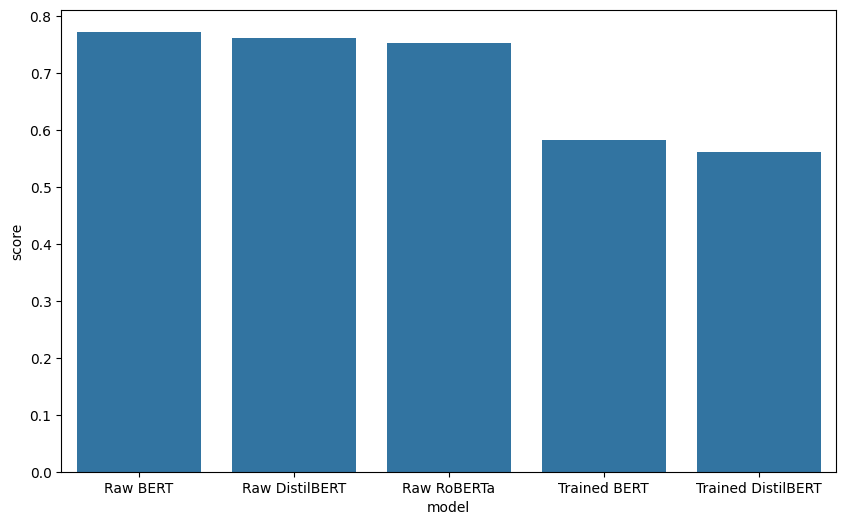

In [6]:
print(df)
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="score", data=df)
plt.show()

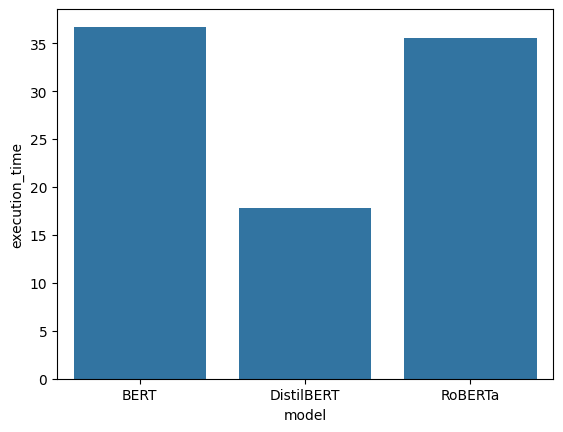

In [10]:
# Plot for static data:
# BERT: 36.72ms
# DistilBERT: 17.83ms
# RoBERTa: 35.59ms

df = pd.DataFrame(columns=["model", "execution_time"])
df.loc[len(df)] = ["BERT", 36.72]
df.loc[len(df)] = ["DistilBERT", 17.83]
df.loc[len(df)] = ["RoBERTa", 35.59]
sns.barplot(x="model", y="execution_time", data=df)
plt.show()

To our surprise, the pretrained models achieved better scores than the fine-tuned ones. We analyzed this behaviour further and noted down our observations in the report. As to the scores between model architectures, there is no significant difference when it comes to the pretrained architectures. This, combined with the fact that DistilBERT executes twice as fast, makes it the best candidate for the use in the pipeline